First the required packages are installed. Numpy allows for large array and matrix operations. Matplotlib is used for plotting the required figures. Cv2 is an open computer vision library, os is used for interacting with the operating system and random is used when randomly shuffling our data. Tqdm is used to show progress bars when iterating. Then we import the optimizer functions from keras. An example of a well known optimizer, that will also be used below is Stochastic Gradient Descent or SGD.

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tqdm import tqdm
from keras import optimizers

print(tf.__version__)

Using TensorFlow backend.


2.1.0


Here we set the working directory and define the datasets. The data is already split into training and testing sets:

In [2]:
DATADIR = r"C:\Users\theod\Desktop\2K19-20 Modules\Deep Learning\dl-medical-imaging\malaria2"
#setting directory
CATEGORIES_TRAINING = ["Infected_train", "Uninfected_train"]
CATEGORIES_TESTING = ["Infected_test", "Uninfected_test"]

The training set is created by appending our empty list in an iterative manner. Progress bars show that the two subsets of the training set (Infected and Uninfected) including the same number of images are complete. Below, we also define our universal variable for image size:

In [3]:
#adjusting image size
IMG_SIZE =50


#creating training data
training_data = []
def create_training_data():
    for category in CATEGORIES_TRAINING:  # do infected & uninfected

        path = os.path.join(DATADIR,category)  # create path to infected & uninfected
        class_num = CATEGORIES_TRAINING.index(category)  # get the classification  (0 or a 1). 0=Infected 1=Uninfected

        for img in tqdm(os.listdir(path)):  # iterate over each image per infected & uninfected
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  #append the array
            except Exception as e: 
                pass
          
create_training_data()

100%|██████████| 9887/9887 [00:28<00:00, 341.76it/s]


The training data is randomly shuffled in order to prevent overfitting (prevent the model from learning that the first 50% of the dataset will always be uninfected). Next, two distinct arrays are created, with to pixel arrays and corresponding labels:


In [4]:
#randomly shuffling the training data           

random.shuffle(training_data)
for sample in training_data[:20]:
    print(sample[1])
print(len(training_data))

x_train = []
y_train = []

for features,label in training_data:
    x_train.append(features)
    y_train.append(label)

1
1
1
0
1
1
1
0
0
1
0
1
0
0
0
0
1
1
0
0
19774


We repeat exactly the same process for the test data, appending in an iterative manner and then randomly shuffling:

In [5]:
#Do the same for test data  
test_data = []
def create_test_data():
    for category in CATEGORIES_TESTING:  # do infected & uninfected

        path = os.path.join(DATADIR,category)  # create path to infected & uninfected
        class_num = CATEGORIES_TESTING.index(category)  # get the classification  (0 or a 1). 0=Infected 1=Uninfected

        for img in tqdm(os.listdir(path)):  # iterate over each image per infected & uninfected
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                test_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:
                pass
 

create_test_data()
random.shuffle(test_data)

print(len(test_data))
x_test = []
y_test = []
for sample in test_data[:20]:
    print(sample[1])
for features,label in test_data:
    x_test.append(features)
    y_test.append(label)
     

100%|██████████| 2786/2786 [00:09<00:00, 294.48it/s]

5512
1
0
1
0
0
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1


Below we transform our lists of pixels in labels into arrays, in order for them to be fed to the neural network

In [6]:
#==============================================================================
#MNIST FASHION
#==============================================================================
train_images = np.array(x_train)
train_labels = np.array(y_train)
test_images = np.array(x_test)
test_labels = np.array(y_test)
class_names = ['Infected','Uninfected']


Below we will plot the first training image. The pixel values range from 0 to 200 due to the colouring of the image:

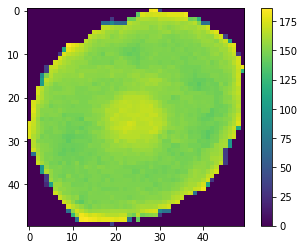

In [7]:
train_images.shape
#prints the first image in the training data:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

We normalize our data. Most of the time coloured images range from 0 pixels (black) to 255 pixels (white). We rescale by dividing each image by 255 in order to get values between 0 and 1. This simplifies the process:

In [8]:
train_images = train_images / 255

test_images = test_images / 255

With the images now ranging from 0 to 1  pixels (grayscale), again plot some of the train images:

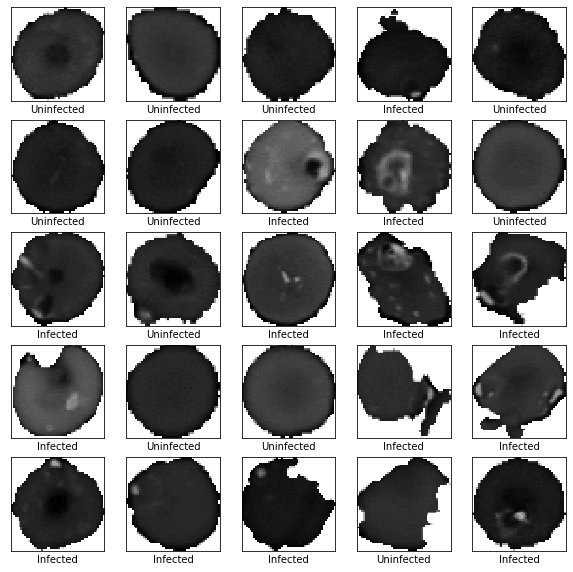

In [9]:
#Plot the first 35 training images:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1) 
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Now we move on to the training phase, starting by flattening the training data. That is, we transform the data from a 50x50 array to a 1 dimensional array of length 50*50 = 2500. Next, we add the fully connected layers. We start with a 600 node ReLU activation, and then we output the data using a softmax layer. Since the classification is binary we could have also used a sigmoid layer for the output, but the 2-probability array is more easily interpreted:

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE)), #Transfprms 2D into 1D i.e lines up pixels
    keras.layers.Dense(600, activation='relu'),
#    keras.layers.Dense(1, activation='sigmoid')#Output single output
    keras.layers.Dense(2, activation = 'softmax')#2 probability scores that add up to one

])

Next, we define our optimiser to be stochastic gradient descent with a learning rate η = 0.005. Furhter, we use sparse categorical crossentropy and use training accuracy as a metric to describe the performance of the model. We iterate 100 times, leading to a running time of approximately 12 minutes. The training accuracy of the model reaches 89% while the test aaccuracy is significantly lower with 70%.

In [11]:
sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='sgd', #model is updated based on loss and data
              loss='sparse_categorical_crossentropy', #Loss function has to be minimised to steer model
              metrics=['accuracy']) # Monitor training and testing sets

model.fit(train_images, train_labels, epochs=100) #fits model to training data
#One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.



test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc) #Comparing loss and accuracy

Train on 19774 samples
Epoch 1/100
19774/19774 [==============================] - 8s 392us/sample - loss: 0.6892 - accuracy: 0.5707
Epoch 2/100
19774/19774 [==============================] - 8s 380us/sample - loss: 0.6532 - accuracy: 0.6099
Epoch 3/100
19774/19774 [==============================] - 8s 419us/sample - loss: 0.6396 - accuracy: 0.6305
Epoch 4/100
19774/19774 [==============================] - 7s 379us/sample - loss: 0.6333 - accuracy: 0.6354
Epoch 5/100
19774/19774 [==============================] - 8s 383us/sample - loss: 0.6245 - accuracy: 0.6497
Epoch 6/100
19774/19774 [==============================] - 7s 363us/sample - loss: 0.6182 - accuracy: 0.6566
Epoch 7/100
19774/19774 [==============================] - 7s 372us/sample - loss: 0.6143 - accuracy: 0.6599
Epoch 8/100
19774/19774 [==============================] - 7s 350us/sample - loss: 0.6099 - accuracy: 0.6629
Epoch 9/100
19774/19774 [==============================] - 7s 366us/sample - loss: 0.6019 - accuracy: 0.6

Below, we use a softmax layer in order to make predictions on the testing data. The following commands will work out the probability of a test image belonging to any of the two classes, returning the label that corresponds to the highest probability:

In [12]:
probability_model = tf.keras.Sequential([model, 
                                        tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

predictions[0]#Shows array of probabilites 
np.argmax(predictions[0])

1

Here we will define two functions for plotting the results. The first plotting funtion returns the images together with both the true and predicted label. Predicted labels are blue if they are the same as the true labels and red if different.

In [13]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array), #100%
                                class_names[true_label]),
                                color=color)

The second function is used to plot the charts indicating the probability of the image belonging in each class. We plot the predictions for the first test image:

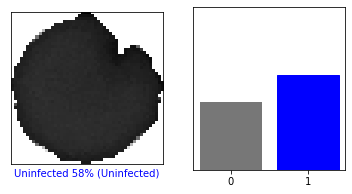

In [14]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  
i = 0 #0th image, correect prediction is blue, incoreect is red
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Finally, we plot the first 15 images together with the corresponding probabilities. Since the test accuracy is only 70% we can see that the model fails to perform the correct predictions for several images:

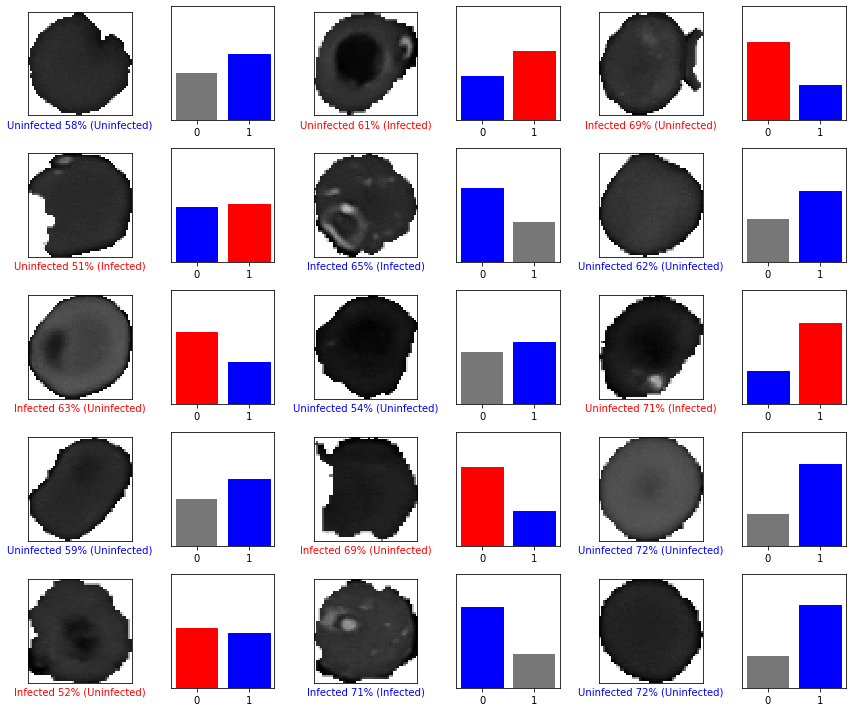

In [15]:
#Predictions for the first 15 images:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Infected


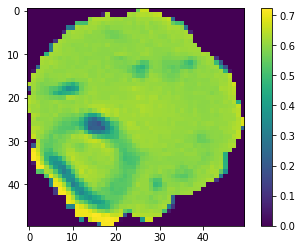

(50, 50)
(1, 50, 50)
[[0.81086284 0.18913719]]


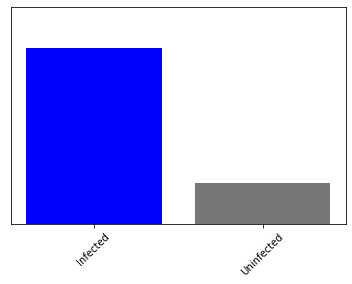

In [16]:
#Prediction for image in test data:



img = test_images[4]
print(class_names[test_labels[4]])
plt.figure()
plt.imshow(test_images[4])
plt.colorbar()
plt.grid(False)
plt.show()

print(img.shape)
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)
predictions_single = model.predict(img)

print(predictions_single)
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(2), class_names, rotation=45)